# Dlib Demo

> Refer to: https://github.com/ageitgey/face_recognition/blob/master/face_recognition/api.py

> Refer to: http://dlib.net, http://dlib.net/files/

## Prepare

### Define dlib model variables

In [3]:
from PIL import Image, ImageFile, ImageDraw

import dlib
import numpy as np
import matplotlib.pyplot as plt

dlib_face_recognition_resnet_model_v1 = 'dlib_face_recognition_resnet_model_v1.dat'
mmod_human_face_detector = 'mmod_human_face_detector.dat'
shape_predictor_5_face_landmarks = 'shape_predictor_5_face_landmarks.dat'
shape_predictor_68_face_landmarks = 'shape_predictor_68_face_landmarks.dat'

ImageFile.LOAD_TRUNCATED_IMAGES = True

### Make dataset

In [111]:
from os import curdir, path
from itertools import chain

import glob
import random as rdm


class Dataset(object):
    def __init__(self):
        pic_dir = path.abspath(path.join(curdir, 'pics'))
        pic_files = set(glob.glob(path.join(pic_dir, '**/*.jpg')))
        self._dataset = self._make_dataset(pic_files)

    @staticmethod
    def _make_dataset(pic_files):
        dataset = {}
        for pf in pic_files:
            key = path.split(path.dirname(pf))[1]
            if key in dataset:
                dataset[key].append(pf)
            else:
                dataset[key] = [pf]
        return dataset

    def one_face(self):
        key = rdm.choice(list(self._dataset.keys()))
        return key, rdm.choice(self._dataset[key])

    def fetch(self, split_count=1):
        train_labels, train_data, test_labels, test_data = [], [], [], []
        for name, files in self._dataset.items():
            test_indices = np.random.choice(len(files), split_count)
            data_indices = np.setdiff1d(np.arange(len(files)), test_indices)

            files = np.array(files)
            train_labels += np.repeat(name, len(data_indices)).tolist()
            train_data += files[data_indices].tolist()

            test_labels += np.repeat(name, len(test_indices)).tolist()
            test_data += files[test_indices].tolist()

        return train_labels, train_data, test_labels, test_data


dataset = Dataset()

### Utils functions

In [5]:
def draw_rectange(img, rect, outline='#fff'):
    for n in range(0, 5):
        box = [(rect[0][0] + n, rect[0][1] + n), (rect[1][0] - n, rect[1][1] - n)]
        draw.rectangle(box, outline=outline)

## Create dlib model download function

In [6]:
import requests
import bz2
from os import curdir, path, makedirs, rename
from urllib.parse import urljoin

def download_model(model_file):
    def make_model_path(model_file, middle_path=''):
        base_dir = path.abspath(path.join(curdir, 'models', middle_path))
        if not path.exists(base_dir):
            makedirs(base_dir, exist_ok=True)

        return path.join(base_dir, model_file)

    local_model_file = make_model_path(model_file)
    if path.exists(local_model_file):
        print('* model file "{}" exsits'.format(model_file))
        return local_model_file

    print('* model file "{}" not exsits'.format(model_file))

    def unzip_bz2(src_file, dest_file):
        with bz2.BZ2File(src_file, 'rb') as src_fp, open(dest_file, 'wb') as dest_fp:
            while 1:
                data = src_fp.read(100 * (1024 ** 2))
                if not data:
                    break
                dest_fp.write(data)

    bz2_model_file = '{}.bz2'.format(model_file)
    bz2_local_model_file = make_model_path(bz2_model_file, middle_path='.cache')
    if path.exists(bz2_local_model_file):
        print('* model bz2 file "{}" exsits, uncompress it...'.format(bz2_local_model_file))
        unzip_bz2(bz2_local_model_file, local_model_file)

        print('* model bz2 file "{}" uncompressed, save as "{}"'.format(bz2_local_model_file, local_model_file))
        return local_model_file

    download_url = urljoin('http://dlib.net/files/', bz2_model_file)
    print('* begin download from url "{}"'.format(download_url))

    r = requests.get(download_url, stream=True, verify=False)
    total_size = int(r.headers.get('Content-Length', -1))
    print('* total file size is {}'.format(total_size))

    download_size = 0
    download_tmp_file = '{}__download.tmp'.format(bz2_local_model_file)
    with open(download_tmp_file, 'wb') as fp:
        print('* create download file "{}"'.format(download_tmp_file))
        for chunk in r.iter_content(chunk_size=10 * (1024 ** 2)):
            if chunk:
                fp.write(chunk)
                download_size += len(chunk)
                print('* {:.2f}kb downloaded'.format(download_size / 1024), end='\r')
            else:
                print('* download completed')

    rename(download_tmp_file, bz2_local_model_file)
    print('* rename "{}" to "{}"'.format(download_tmp_file, bz2_local_model_file))

    unzip_bz2(bz2_local_model_file, local_model_file)
    print('* model bz2 file "{}" uncompressed, save as "{}"'.format(bz2_local_model_file, local_model_file))
    
    return local_model_file

## Face detect

- Load face image

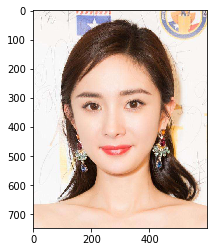

In [41]:
_, face_file = dataset.one_face()
detect_im = np.array(Image.open(face_file).convert('RGB'))

plt.imshow(detect_im)
plt.show()

### HOG algorithm

* 1 faces detected, boxes is "rectangles[[(134, 241) (455, 562)]]"


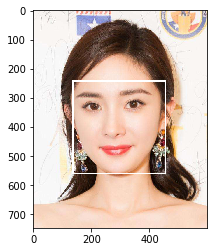

In [42]:
face_detector = dlib.get_frontal_face_detector()

boxes = face_detector(detect_im, 1)
print('* {} faces detected, boxes is "{}"'.format(len(boxes), boxes))

img = Image.fromarray(detect_im)
draw = ImageDraw.Draw(img)

for box in boxes:
    box = [(box.left(), box.top()), (box.right(), box.bottom())]
    draw_rectange(draw, box, outline='#fff')

plt.imshow(img)
plt.show()

### CNN algorithm

* 1 faces detected, boxes is "[rectangle(128,233,422,526)]"


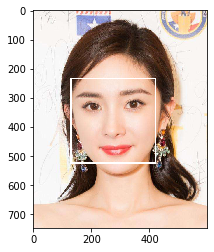

In [64]:
if 'cnn_face_detector' not in locals():
    model_file = download_model(mmod_human_face_detector)
    cnn_face_detector = dlib.cnn_face_detection_model_v1(model_file)

boxes = [b.rect for b in cnn_face_detector(detect_im, 1)]
print('* {} faces detected, boxes is "{}"'.format(len(boxes), boxes))

img = Image.fromarray(detect_im)
draw = ImageDraw.Draw(img)

for box in boxes:
    box = [(box.left(), box.top()), (box.right(), box.bottom())]
    draw_rectange(draw, box, outline='#fff')

plt.imshow(img)
plt.show()

## Face landmark

- 5 points landmark

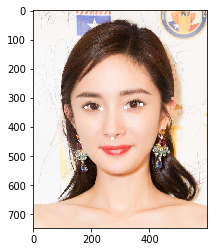

In [90]:
if 'pose_predictor_5_point' not in locals():
    model_file = download_model(shape_predictor_5_face_landmarks)
    pose_predictor_5_point = dlib.shape_predictor(model_file)

raw_landmarks = [pose_predictor_5_point(detect_im, b) for b in boxes]
landmarks = [[(p.x, p.y) for p in landmark.parts()] for landmark in raw_landmarks]

img = Image.fromarray(detect_im)
draw = ImageDraw.Draw(img)

for points in landmarks:
    for p in points:
        draw.ellipse((p[0] - 5, p[1] - 5, p[0] + 5, p[1] + 5), fill='#fff')

plt.imshow(img)
plt.show()

- 68 points landmark

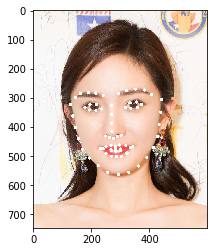

In [92]:
if 'pose_predictor_68_point' not in locals():
    model_file = download_model(shape_predictor_68_face_landmarks)
    pose_predictor_68_point = dlib.shape_predictor(model_file)
    
raw_landmarks = [pose_predictor_68_point(detect_im, b) for b in boxes]
landmarks = [[(p.x, p.y) for p in landmark.parts()] for landmark in raw_landmarks]

img = Image.fromarray(detect_im)
draw = ImageDraw.Draw(img)

for points in landmarks:
    for p in points:
        draw.ellipse((p[0] - 5, p[1] - 5, p[0] + 5, p[1] + 5), fill='#fff')

plt.imshow(img)
plt.show()

- named landmark

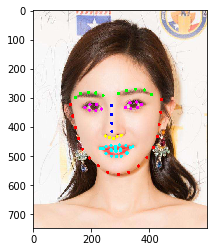

In [93]:
if len(landmarks[0]) == 5:
    named_landmarks = [{
        'nose_tip': [points[4]],
        'left_eye': points[2:4],
        'right_eye': points[0:2],
    } for points in landmarks]
else:
    named_landmarks = [{
        'chin': points[0:17],
        'left_eyebrow': points[17:22],
        'right_eyebrow': points[22:27],
        'nose_bridge': points[27:31],
        'nose_tip': points[31:36],
        'left_eye': points[36:42],
        'right_eye': points[42:48],
        'top_lip': points[48:55] + [points[64]] + [points[63]] + [points[62]] + [points[61]] + [points[60]],
        'bottom_lip': points[54:60] + [points[48]] + [points[60]] + [points[67]] + [points[66]] + [points[65]] + [points[64]]
    } for points in landmarks]

img = Image.fromarray(detect_im)
draw = ImageDraw.Draw(img)

def draw_points(points, color):
    for p in points:
        draw.ellipse((p[0] - 5, p[1] - 5, p[0] + 5, p[1] + 5), fill=color)

for nl in named_landmarks:
    if 'chin' in nl:
        draw_points(nl['chin'], color='#F00')
        
    if 'left_eyebrow' in nl and 'right_eyebrow' in nl:
        draw_points(nl['left_eyebrow'], color='#0F0')
        draw_points(nl['right_eyebrow'], color='#0F0')
        
    if 'nose_bridge' in nl:
        draw_points(nl['nose_bridge'], color='#00F')
        
    if 'nose_tip' in nl:
        draw_points(nl['nose_tip'], color='#FF0')
        
    if 'left_eye' in nl and 'right_eye' in nl:
        draw_points(nl['left_eye'], color='#F0F')
        draw_points(nl['right_eye'], color='#F0F')
        
    if 'top_lip' in nl and 'bottom_lip' in nl:
        draw_points(nl['top_lip'], color='#0FF')
        draw_points(nl['bottom_lip'], color='#0FF')


plt.imshow(img)
plt.show()

## Face recognize

- Prepare images

In [115]:
raw_train_labels, raw_train_data, raw_test_labels, raw_test_data = dataset.fetch()
print('* load {} picture for tainning, and {} pictures for testing'.format(len(raw_train_labels), len(test_labels)))

raw_train_data = [np.array(Image.open(file).convert('RGB')) for file in train_data]
test_data = [np.array(Image.open(file).convert('RGB')) for file in test_data]

* load 4 picture for tainning, and 2 pictures for testing


- Load face recognize model

In [119]:
if 'face_detector' not in locals():
    face_detector = dlib.get_frontal_face_detector()

if 'pose_predictor_5_point' not in locals():
    model_file = download_model(shape_predictor_5_face_landmarks)
    pose_predictor_5_point = dlib.shape_predictor(model_file)

if 'face_encoder' not in locals():
    model_file = download_model(dlib_face_recognition_resnet_model_v1)
    face_encoder = dlib.face_recognition_model_v1(model_file)

- Encoding all faces

In [138]:
from itertools import repeat

def encoding_facees(label, im):
    locations = face_detector(im)
    landmarks = [pose_predictor_5_point(im, l) for l in locations]
    return (list(repeat(label, len(locations))),
            np.array([face_encoder.compute_face_descriptor(detect_im, landmark, 2) for landmark in raw_landmarks]))

fixed_train_labels
for label, im in zip(train_labels, train_data):
    

train_encodings = [encoding_facees(label, im) 
print(train_encodings)
test_encodings = [encoding_face(im) for im in test_data]

[(['刘德华'], array([[-0.07266873,  0.03891908,  0.04230238, -0.06619134, -0.10205103,
        -0.00265429, -0.13478372, -0.10285821,  0.13819468, -0.1815052 ,
         0.15530428, -0.0710402 , -0.20407012,  0.02820594, -0.07759646,
         0.23298365, -0.24762708, -0.17494169,  0.0241123 , -0.03680127,
         0.02096896,  0.0393635 , -0.00880137,  0.05475003, -0.1471276 ,
        -0.34376642, -0.13229474, -0.07021863, -0.06476562, -0.06283946,
        -0.07946085,  0.06718724, -0.13443267,  0.05199786,  0.07928431,
         0.06919042,  0.0328999 , -0.13384503,  0.15762487,  0.06530519,
        -0.24374354,  0.06011168,  0.12206432,  0.20089605,  0.15499073,
        -0.01487924, -0.0212385 , -0.17457175,  0.17663971, -0.13247925,
         0.02445786,  0.15500726,  0.11805521,  0.09206823, -0.00443243,
        -0.08180083,  0.04396075,  0.13635278, -0.17379779, -0.00561087,
         0.08042447, -0.05212305,  0.01950237, -0.10445495,  0.17692006,
         0.13913128, -0.09640127, -0.252

- Calculate distance of faces

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
